In [317]:
import pandas as pd
import netCDF4
import matplotlib.pyplot as plt
import numpy as np
import itertools
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.optimizers import Adam, Adamax, RMSprop, SGD

# Early stoping
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# Pustaka untuk  evaluasi model prediksi
from math import sqrt
from sklearn.metrics import mean_squared_error

# pustaka untuk waktu komputasi
import time
from datetime import datetime

ImportError: cannot import name 'Adam' from 'keras.optimizers' (C:\Users\ACER\anaconda3\lib\site-packages\keras\optimizers.py)

### Praproses data CRU TS

In [ ]:
# https://help.ceda.ac.uk/article/4728-cru-data-python-example

# 'lat' for latitudes
# 'lon' for longitudes
# 'time' for time

# cloud cover (cld), diurnal temperature range (dtr), frost day frequency (frs), precipitation (pre), 
# daily mean temperature (tmp), monthly average daily maximum (tmx) and minimum (tmn) temperature,
# vapour pressure (vap), Potential Evapo-transpiration (pet) and wet day frequency (wet)

variabel = ['cld', 'dtr', 'frs', 'pet', 'pre', 'tmn', 'tmp', 'tmx', 'vap', 'wet']
fp=[r'D:\UIN\BigData\UAS\dataset\ceda\cru_ts4.05.2001.2010.cld.dat.nc',
    r'D:\UIN\BigData\UAS\dataset\ceda\cru_ts4.05.2001.2010.dtr.dat.nc',
    r'D:\UIN\BigData\UAS\dataset\ceda\cru_ts4.05.2001.2010.frs.dat.nc',
    r'D:\UIN\BigData\UAS\dataset\ceda\cru_ts4.05.2001.2010.pet.dat.nc',
    r'D:\UIN\BigData\UAS\dataset\ceda\cru_ts4.05.2001.2010.pre.dat.nc',
    r'D:\UIN\BigData\UAS\dataset\ceda\cru_ts4.05.2001.2010.tmn.dat.nc',
    r'D:\UIN\BigData\UAS\dataset\ceda\cru_ts4.05.2001.2010.tmp.dat.nc',
    r'D:\UIN\BigData\UAS\dataset\ceda\cru_ts4.05.2001.2010.tmx.dat.nc',
    r'D:\UIN\BigData\UAS\dataset\ceda\cru_ts4.05.2001.2010.vap.dat.nc',
    r'D:\UIN\BigData\UAS\dataset\ceda\cru_ts4.05.2001.2010.wet.dat.nc']

# buat dataframe berisi time, lat, lon
data= netCDF4.Dataset(fp[0])
time = data.variables['time'][:]
lat = data.variables['lat'][:]
lon = data.variables['lon'][:]
stn = data.variables['stn'][:]


# kolom date
d = pd.date_range(start='1/1/2001', end='12/1/2010', freq='MS').date
date = np.array(d)
date = np.repeat(date, 259200)
df_2001_2010 = pd.DataFrame(date, columns = ['date'])

# kolom lat(360), lon(720)
lons,lats = np.meshgrid(data.variables['lon'][:], data.variables['lat'][:]) 
x,y = map(lons, lats)
x = x.flatten()
y = y.flatten()

x = np.tile(x,120)
y = np.tile(y,120)

df_2001_2010['latitude'] = y
df_2001_2010['longitude'] = x

# sld
sld = data.variables[variabel[0]][:]
sld= np.array(sld)
sld= sld.flatten()
df_2001_2010['sld'] = sld


# tambah kolom variabel bebas lain
for i in range(1,len(fp)):
    data= netCDF4.Dataset(fp[i])
    temp = data.variables[variabel[i]][:]
    temp= np.array(temp)
    temp= temp.flatten()
    df_2001_2010[variabel[i]] = temp

# print(df_2001_2010)

# max, min
lat_indo = [5.6701, -10.934]
lon_indo = [140.9419, 95.1345]

df_2001_2010 = df_2001_2010.drop(df_2001_2010[(df_2001_2010['latitude'] > lat_indo[0]) | (df_2001_2010['latitude'] < lat_indo[1])].index)
df_2001_2010 = df_2001_2010.drop(df_2001_2010[(df_2001_2010['longitude'] > lon_indo[0]) | (df_2001_2010['longitude'] < lon_indo[1])].index)
print(len(df_2001_2010))


# df_2001_2010.to_csv(r'D:\UIN\BigData\UAS\hasil\ceda_2001_2010_indo.csv')

In [321]:
# https://help.ceda.ac.uk/article/4728-cru-data-python-example
import pandas as pd
import netCDF4
import matplotlib.pyplot as plt
import numpy as np

# 'lat' for latitudes
# 'lon' for longitudes
# 'time' for time
# 'tmp' for near surface temperature
variabel = ['cld', 'dtr', 'frs', 'pet', 'pre', 'tmn', 'tmp', 'tmx', 'vap', 'wet']
fp=[r'D:\UIN\BigData\UAS\dataset\ceda\cru_ts4.05.2011.2020.cld.dat.nc',
    r'D:\UIN\BigData\UAS\dataset\ceda\cru_ts4.05.2011.2020.dtr.dat.nc',
    r'D:\UIN\BigData\UAS\dataset\ceda\cru_ts4.05.2011.2020.frs.dat.nc',
    r'D:\UIN\BigData\UAS\dataset\ceda\cru_ts4.05.2011.2020.pet.dat.nc',
    r'D:\UIN\BigData\UAS\dataset\ceda\cru_ts4.05.2011.2020.pre.dat.nc',
    r'D:\UIN\BigData\UAS\dataset\ceda\cru_ts4.05.2011.2020.tmn.dat.nc',
    r'D:\UIN\BigData\UAS\dataset\ceda\cru_ts4.05.2011.2020.tmp.dat.nc',
    r'D:\UIN\BigData\UAS\dataset\ceda\cru_ts4.05.2011.2020.tmx.dat.nc',
    r'D:\UIN\BigData\UAS\dataset\ceda\cru_ts4.05.2011.2020.vap.dat.nc',
    r'D:\UIN\BigData\UAS\dataset\ceda\cru_ts4.05.2011.2020.wet.dat.nc']

# buat dataframe berisi time, lat, lon
data= netCDF4.Dataset(fp[0])
time = data.variables['time'][:]
lat = data.variables['lat'][:]
lon = data.variables['lon'][:]
stn = data.variables['stn'][:]

# kolom date
d = pd.date_range(start='1/1/2011', end='12/1/2020', freq='MS').date
date = np.array(d)
date = np.repeat(date, 259200)
df_2011_2020 = pd.DataFrame(date, columns = ['date'])

# kolom lat(360), lon(720)
lons,lats = np.meshgrid(data.variables['lon'][:], data.variables['lat'][:]) 
x,y = map(lons, lats)
x = x.flatten()
y = y.flatten()

x = np.tile(x,120)
y = np.tile(y,120)

df_2011_2020['latitude'] = y
df_2011_2020['longitude'] = x

# sld
sld = data.variables[variabel[0]][:]
sld= np.array(sld)
sld= sld.flatten()
df_2011_2020['sld'] = sld

# tambah kolom variabel bebas lain
for i in range(1,len(fp)):
    data= netCDF4.Dataset(fp[i])
    temp = data.variables[variabel[i]][:]
    temp= np.array(temp)
    temp= temp.flatten()
    df_2011_2020[variabel[i]] = temp

# print(df_2011_2020)

# max, min
lat_indo = [5.6701, -10.934]
lon_indo = [140.9419, 95.1345]

df_2011_2020 = df_2011_2020.drop(df_2011_2020[(df_2011_2020['latitude'] > lat_indo[0]) | (df_2011_2020['latitude'] < lat_indo[1])].index)
df_2011_2020 = df_2011_2020.drop(df_2011_2020[(df_2011_2020['longitude'] > lon_indo[0]) | (df_2011_2020['longitude'] < lon_indo[1])].index)
print(len(df_2011_2020))


# df_2011_2020.to_csv(r'D:\UIN\BigData\UAS\hasil\ceda_2001_2010_indo.csv')

364320


In [200]:
# gabungkan data
frames = [df_2001_2010, df_2011_2020]
  
df_2001_2020 = pd.concat(frames)
print(len(df_2001_2020))

# df_2001_2020.to_csv(r'D:\UIN\BigData\UAS\hasil\ceda_2001_2020_indo.csv')

728640


### Read Dataset

In [281]:
# baca dataset bmkg
df_bmkg = pd.read_csv(r'D:\UIN\BigData\UAS\hasil\bmkg_2001_2020_sumsel_clipped.csv')
df_bmkg = df_bmkg.drop(columns=['Unnamed: 0'])
print(df_bmkg)

# df yang disimpan memiliki 3 buah titik(long, lat) untuk tiap tanggal
# tiap param akan dikalkulasi meannya
# sehingga tidak ada duplikasi tanggal

# df_ceda = pd.read_csv(r'D:\UIN\BigData\UAS\hasil\ceda_2001_2020_sumsel_clipped.csv')
# df_ceda = df_ceda.drop(columns=['field_1', 'latitude', 'longitude'])
# df_ceda = df_ceda.groupby('date').mean()

# baca dataset ceda
df_ceda = pd.read_csv(r'D:\UIN\BigData\UAS\hasil\ceda_2001_2020_sumsel_clipped2.csv')
# copy hotspot karena variabel terikat sama
df_ceda['hotspot'] = df_bmkg['hotspot']
print(df_ceda)



         Bulan       Suhu  Kelembapan  Curah_Hujan  Radiasi_Matahari  \
0    2001-01-1  26.167742   88.548387    13.783871          2.822581   
1    2001-02-1  26.589286   85.750000     7.760714          3.821429   
2    2001-03-1  26.841935   84.161290    10.835484          4.083871   
3    2001-04-1  27.340000   84.466667    13.856667          4.726667   
4    2001-05-1  27.441935   86.161290     4.708065          5.029032   
..         ...        ...         ...          ...               ...   
235  2020-08-1  28.270968   79.483871     1.803226          6.122581   
236  2020-09-1  27.975000   80.066667     5.616667          4.438333   
237  2020-10-1  27.629032   83.838710     9.191935          3.938710   
238  2020-11-1  27.573333   84.600000    14.250000          4.693333   
239  2020-12-1  27.058065   86.741935    12.998387          3.019355   

     Kecepatan_Angin  hotspot  
0           1.838710        3  
1           1.821429        5  
2           0.580645       10  
3      

### Normalisasi

In [288]:
# dataset bmkg
scaler = MinMaxScaler()
df_bmkg[['Suhu', 'Kelembapan', 'Curah_Hujan', 'Radiasi_Matahari', 'Kecepatan_Angin']] = scaler.fit_transform(df_bmkg[['Suhu', 'Kelembapan', 'Curah_Hujan', 'Radiasi_Matahari', 'Kecepatan_Angin']])
print(df_bmkg)

# dataset ceda
df_ceda[['sld', 'dtr', 'frs', 'pet', 'pre', 'tmn', 'tmp', 'tmx', 'vap', 'wet']] = scaler.fit_transform(df_ceda[['sld', 'dtr', 'frs', 'pet', 'pre', 'tmn', 'tmp', 'tmx', 'vap', 'wet']])
print(df_ceda)

Index(['date', 'sld', 'dtr', 'frs', 'pet', 'pre', 'tmn', 'tmp', 'tmx', 'vap',
       'wet', 'hotspot'],
      dtype='object')
         Bulan      Suhu  Kelembapan  Curah_Hujan  Radiasi_Matahari  \
0    2001-01-1  0.082707    0.859287     0.557433          0.292132   
1    2001-02-1  0.223070    0.724245     0.313851          0.452944   
2    2001-03-1  0.307197    0.647579     0.438197          0.495196   
3    2001-04-1  0.473040    0.662315     0.560377          0.598684   
4    2001-05-1  0.506982    0.744093     0.190399          0.647364   
..         ...       ...         ...          ...               ...   
235  2020-08-1  0.783029    0.421860     0.072924          0.823422   
236  2020-09-1  0.684479    0.449984     0.227143          0.552263   
237  2020-10-1  0.569280    0.632012     0.371730          0.471825   
238  2020-11-1  0.550734    0.668750     0.576283          0.593318   
239  2020-12-1  0.379162    0.772113     0.525667          0.323812   

     Kecepatan_Angin 

### Visualisasi

In [318]:
filename = r'D:\UIN\BigData\UAS\dataset\ceda\cru_ts4.05.2001.2010.tmp.dat.nc'
data = netCDF4.Dataset(filename)
temp = data.variables['tmp'][:]
temp_av_2001_2010= np.mean(temp[:,:,:],axis = 0)

<ipython-input-319-fad7996f494f>:7: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = map.colorbar(temp_plot, "bottom", size="5%", pad="2%", extend = 'both')


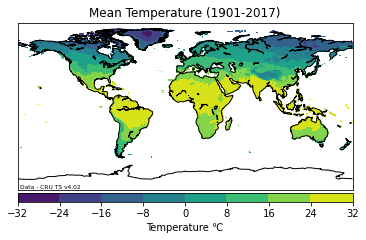

In [319]:
plt.figure()
map = Basemap(projection="cyl", resolution='c', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180) 
map.drawcoastlines(color="black") 
lons,lats = np.meshgrid(data.variables['lon'][:], data.variables['lat'][:]) 
x,y = map(lons, lats)
temp_plot = map.contourf(x, y, temp_av_2001_2010, cmap=plt.cm.viridis) 
cb = map.colorbar(temp_plot, "bottom", size="5%", pad="2%", extend = 'both')
cb.set_label(u"Temperature \u2103")
plt.title("Mean Temperature (1901-2017)")
plt.annotate('Data - CRU TS v4.02',(-178,-88), fontsize=6)
plt.show()

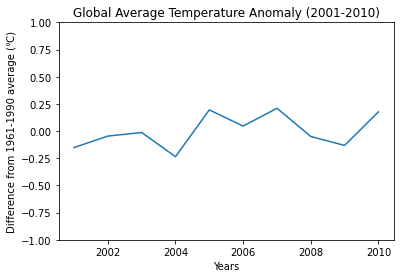

<Figure size 432x288 with 0 Axes>

In [320]:
global_average= np.mean(temp[:,:,:],axis=(1,2))
annual_temp = np.mean(np.reshape(global_average, (10,12)), axis = 1)
av_2001_2010=np.mean(annual_temp)

temp_anomaly = annual_temp - av_2001_2010

plt.figure()
plt.plot(np.arange(2001,2011,1),temp_anomaly)
plt.ylim(np.floor(min(temp_anomaly)), np.ceil(max(temp_anomaly))) 
plt.title("Global Average Temperature Anomaly (2001-2010)")
plt.xlabel("Years") 
plt.ylabel(u"Difference from 1961-1990 average (\u2103)") 
plt.show()
plt.savefig('temp_anom_ts.png')

In [290]:
# monthly = global_average
# plt.figure()
# plt.plot(time,monthly)
# plt.ylim(np.floor(min(monthly)), np.ceil(max(monthly))) 
# plt.title("Global Average Temperature Anomaly (1901-2017)")
# plt.xlabel("Years") 
# plt.ylabel(u"Difference from 1961-1990 average (\u2103)") 
# plt.show()

### pembagian data

In [302]:
# Split Validasi(train 80%, test 20%)

## dataset bmkg
bmkg_x = df_bmkg[['Suhu', 'Kelembapan', 'Curah_Hujan', 'Radiasi_Matahari', 'Kecepatan_Angin']]
bmkg_y = df_bmkg['hotspot']
x_train_bmkg, x_test_bmkg, y_train_bmkg, y_test_bmkg = train_test_split(bmkg_x, bmkg_y, test_size=0.2, random_state=1)

## dataset ceda
ceda_x = df_ceda[['sld', 'dtr', 'frs', 'pet', 'pre', 'tmn', 'tmp', 'tmx', 'vap', 'wet']]
ceda_y = df_ceda['hotspot']
x_train_ceda, x_test_ceda, y_train_ceda, y_test_ceda = train_test_split(ceda_x, ceda_y, test_size=0.2, random_state=1)

print(x_train_ceda.shape, x_test_ceda.shape, y_train_ceda.shape, y_test_ceda.shape)

(192, 10) (48, 10) (192,) (48,)


### pembuatan arsitektur NN : Hyperparameter GridSearchCV LTSM-RNN

In [313]:
# parameter
parameters = {'neurons' : [8, 16],
              'activation' : ['sigmoid', 'tanh', 'relu', 'selu', 'elu', 'softplus'],
              'optimizer' : ['adam', 'adamax', 'rmsprop', 'sgd'],
              'dropout_rate' : [0.1],
              'epochs' : [260, 500, 1000, 1500, 2000],
              'batch_size' : [8, 16, 32, 64],
              'verbose' : [0]}

In [314]:
keys = parameters.keys()
values = (parameters[key] for key in keys)
combinations = [dict(zip(keys, combination)) for combination in itertools.product(*values)]
print(len(combinations), str('kombinasi hyperparameter'))

960 kombinasi hyperparameter


In [315]:
def build_classifier(neurons='', activation='', optimizer='', dropout_rate=''):
    tf.keras.backend.clear_session()
    
    # design network
    grid_model = Sequential()
    grid_model.add(LSTM(units=neurons, activation=activation, input_shape=(train_X.shape[1], train_X.shape[2])))
    grid_model.add(Dropout(dropout_rate))
    grid_model.add(Dense(1))

    # model compile
    grid_model.compile(loss='mae', optimizer=optimizer)
    
    # return value
    return grid_model

In [316]:
grid_model = KerasRegressor(build_fn=build_classifier)

<ipython-input-316-7861529788ff>:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  grid_model = KerasRegressor(build_fn=build_classifier)


In [ ]:
grid_search = GridSearchCV(estimator=grid_model, param_grid=parameters, n_jobs=-1, cv=2, scoring= 'neg_root_mean_squared_error')

In [ ]:
grid_result = grid_search.fit(x_train_bmkg, y_train_bmkg)

In [ ]:
# summarize results
print("Best parameters: %f using %s\n" % (grid_search.best_score_, grid_search.best_params_))

means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

### deep learning

### rmse dan waktu